In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L1VzZXJzL2phbWVzZG9zcy1nb2xsaW4vRG9jdW1lbnRzL3RlYWNoaW5nL2NsaW1hdGUtcmlzay1tYW5hZ2VtZW50LWJvb2svY2hhcHRlcnMvZnVuZGFtZW50YWxz"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| code-fold: true
#| output: false
using CairoMakie
using Distributions
using LaTeXStrings

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


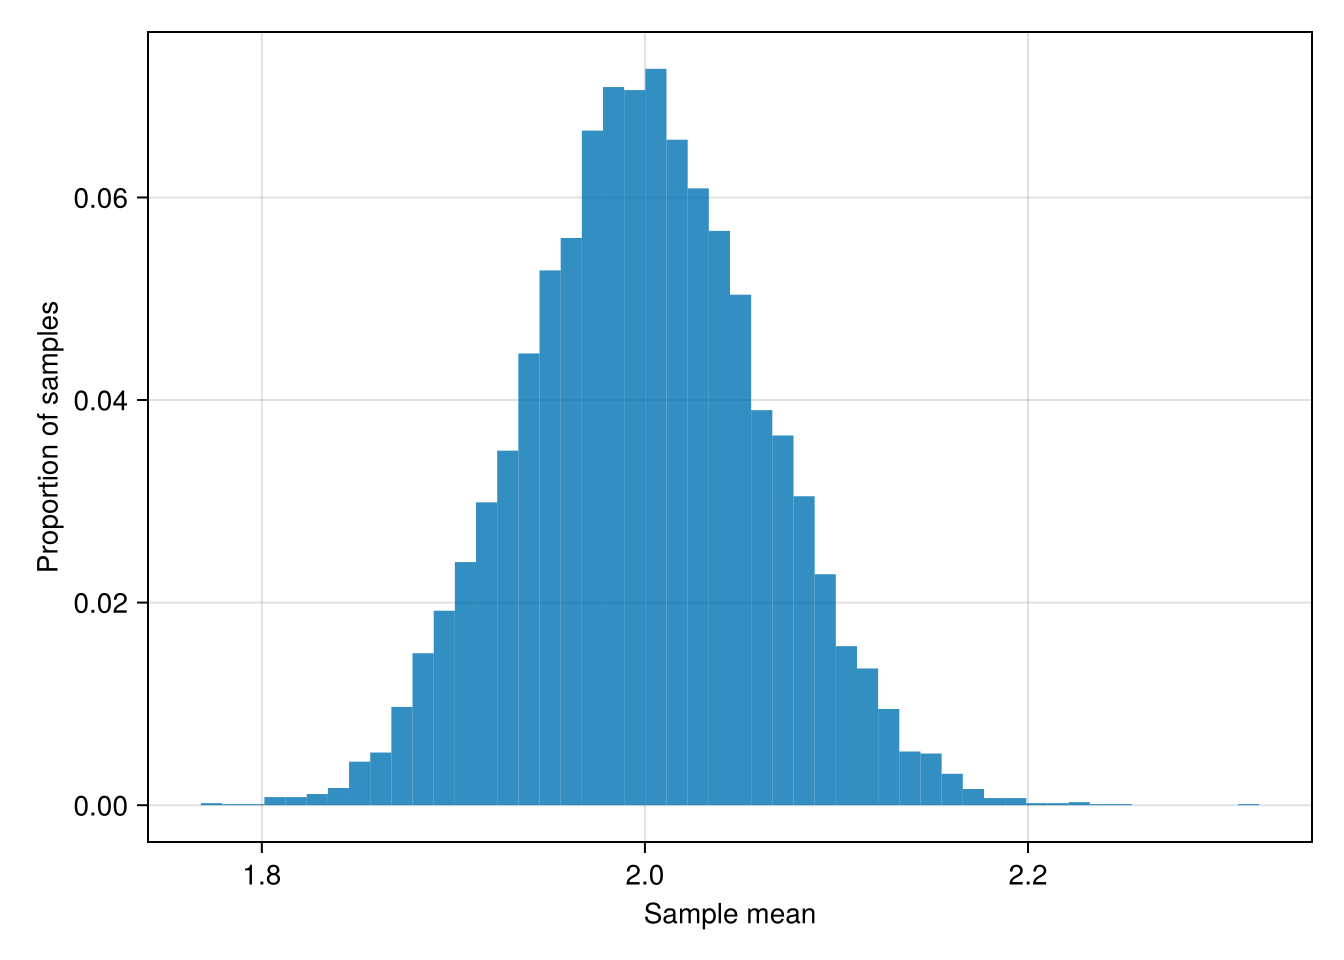

In [3]:
dist = Gamma(2, 1) # a non-Gaussian distribution
N = 10_000 # number of samples
J = 500 # draws per sample
ȳ = [ # <1>
    mean(rand(dist, J)) for _ in 1:N # <2>
] # <3>
hist(
    ȳ;
    bins=50,
    axis=(
        xlabel="Sample mean",
        ylabel="Proportion of samples",
    ),
    normalization=:probability
)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


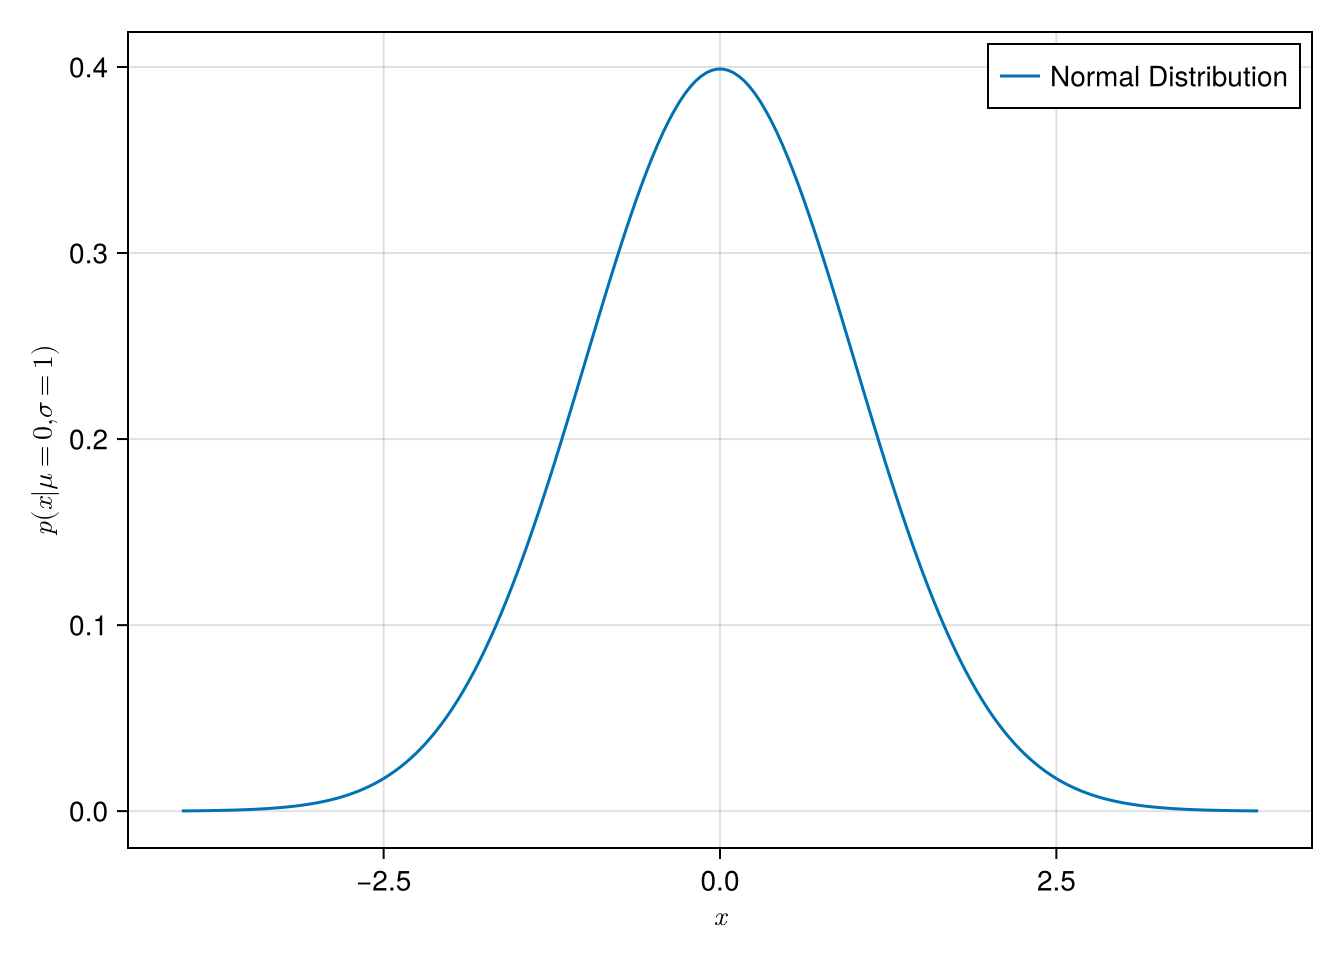

In [4]:
let
    dist = Normal(0, 1)
    x = range(-4, 4, 200)
    y = pdf.(dist, x)

    fig = Figure()
    ax = Axis(fig[1, 1],
        xlabel=L"$x$",
        ylabel=L"$p(x | \mu=0, \sigma=1)$"
    )
    lines!(ax, x, y, label="Normal Distribution")
    axislegend()
    fig
end

In [5]:
p = 0.5 # probability of heads
rand(Bernoulli(p), 5) # <1>

5-element Vector{Bool}:
 0
 1
 1
 0
 1

In [6]:
p = 0.5
N = 5
rand(Binomial(N, p), 5)

5-element Vector{Int64}:
 3
 1
 1
 0
 4

In [7]:
p = [0.5, 0.3, 0.2]
N = 5
dist = Multinomial(N, p)
rand(dist, 5) # <1>

3×5 Matrix{Int64}:
 2  4  2  2  2
 2  0  2  0  1
 1  1  1  3  2

In [8]:
dist = Poisson(2.5) # <1>
rand(dist, 10) # <2>

10-element Vector{Int64}:
 3
 2
 4
 7
 2
 4
 4
 2
 1
 2

In [9]:
## https://www.matecdev.com/posts/julia-numerical-integration.html
function quad_trap(f, a, b, N)
    h = (b - a) / N
    int = h * (f(a) + f(b)) / 2
    for k in 1:(N-1)
        xk = (b - a) * k / N + a
        int = int + h * f(xk)
    end
    return int
end;

In [10]:
dist = Normal() ## <1>
f(x) = pdf(dist, x) ## <2>
approx = quad_trap(f, -100, 2, 1000) ## <3>
exact = cdf(dist, 2)

approx, exact

(0.9771562639858903, 0.9772498680518208)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


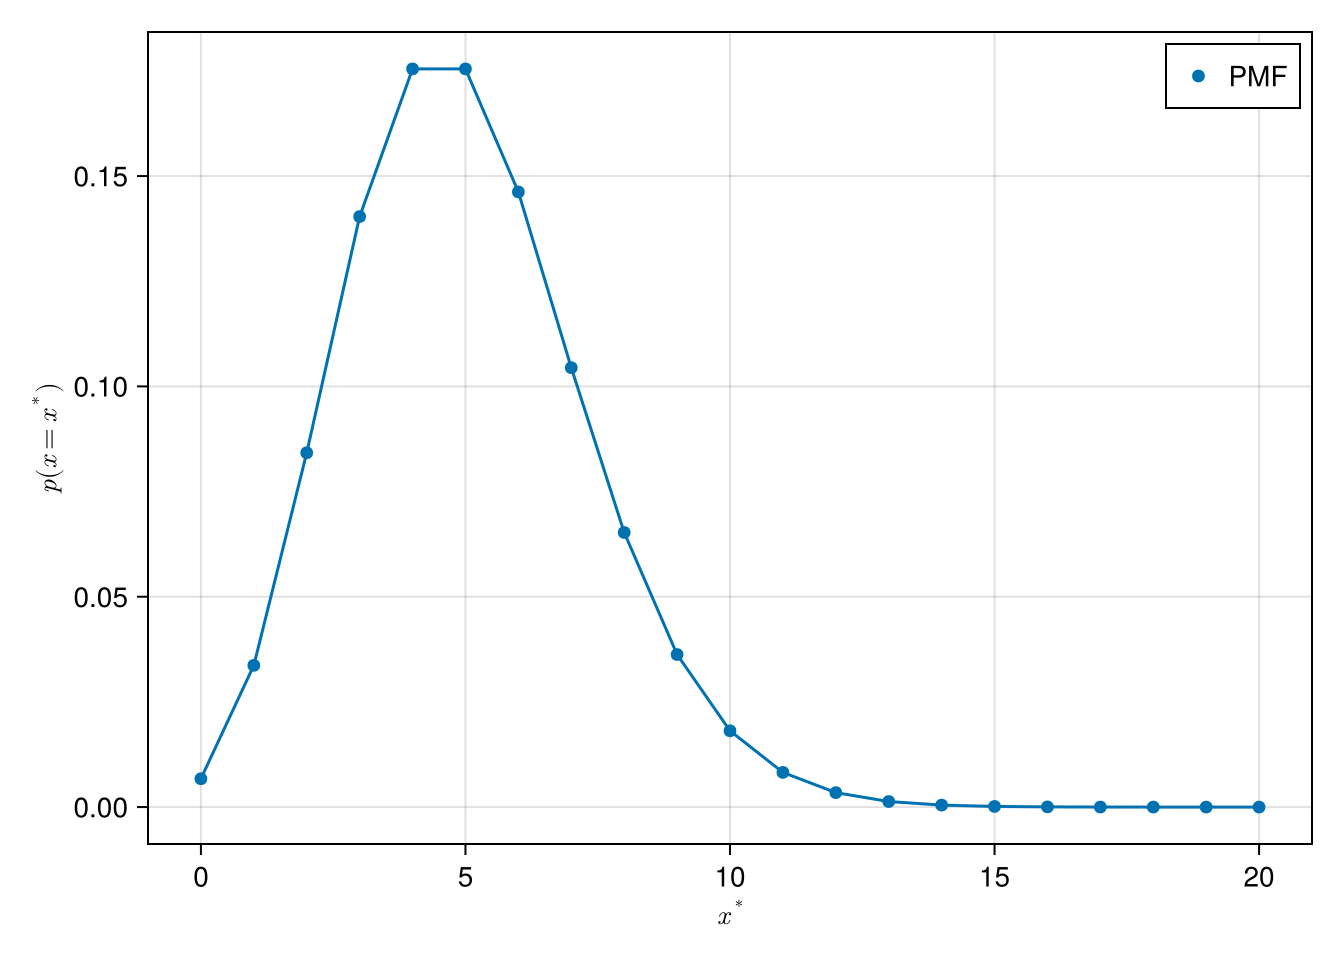

In [11]:
x = 0:20
y = pdf.(Poisson(5), x)
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel=L"x^*",
    ylabel=L"p(x=x^*)"
)
scatter!(ax, x, y; label="PMF")
lines!(ax, x, y)
axislegend()
fig

In [12]:
#| output: false
m = 2
b = 1
σ = 1.5

1.5

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


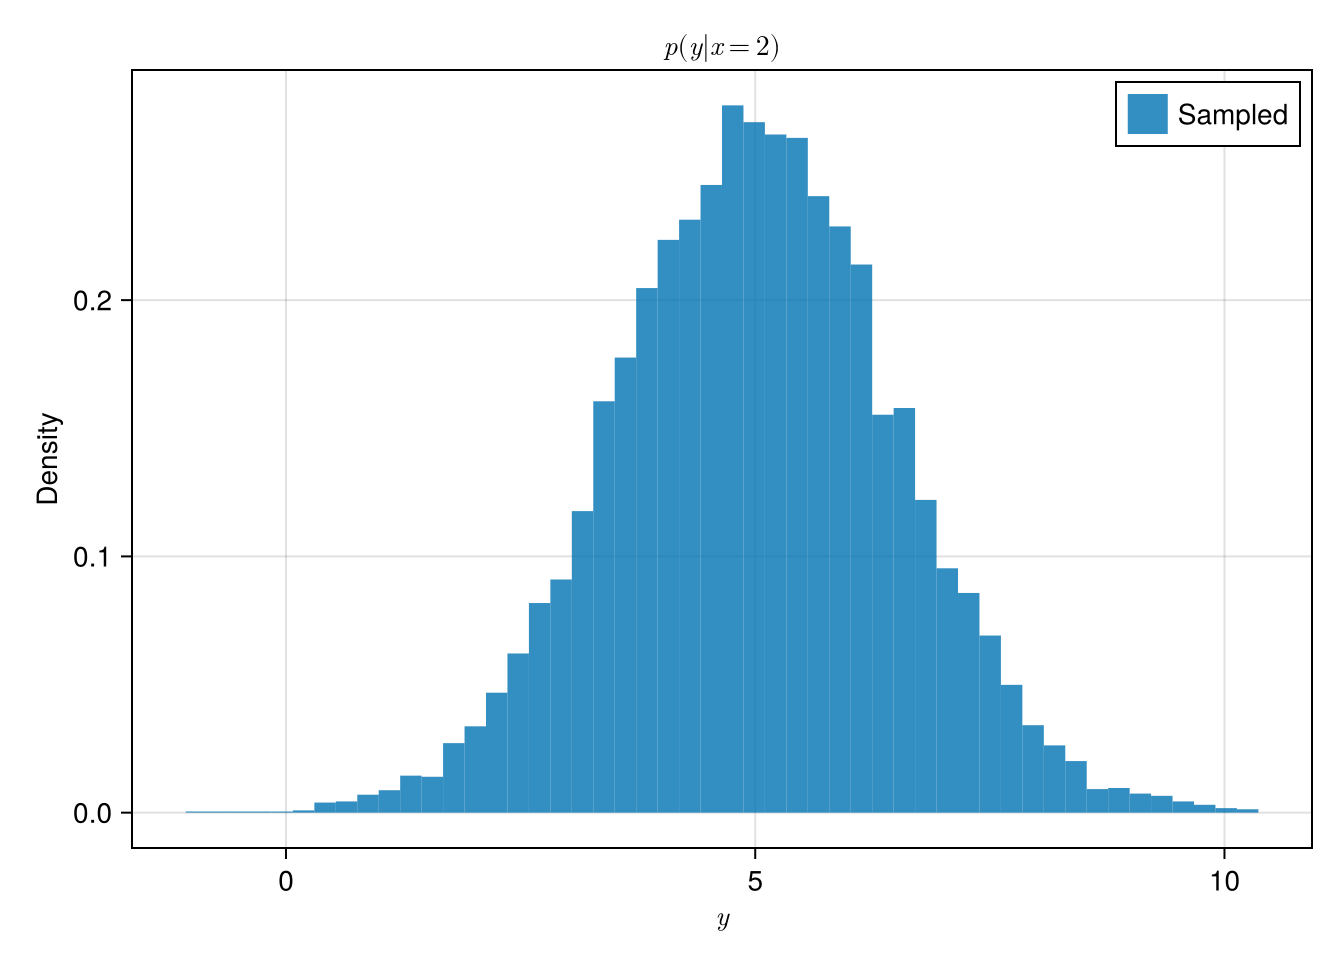

In [13]:
N_sim = 10_000
x = 2
y = rand(Normal(m * x + b, σ), N_sim)

fig = Figure()
ax = Axis(fig[1, 1],
    title=L"p(y | x=2)",
    xlabel=L"y",
    ylabel="Density"
)
hist!(ax, y; bins=50, normalization=:pdf, label="Sampled")
axislegend()
fig

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


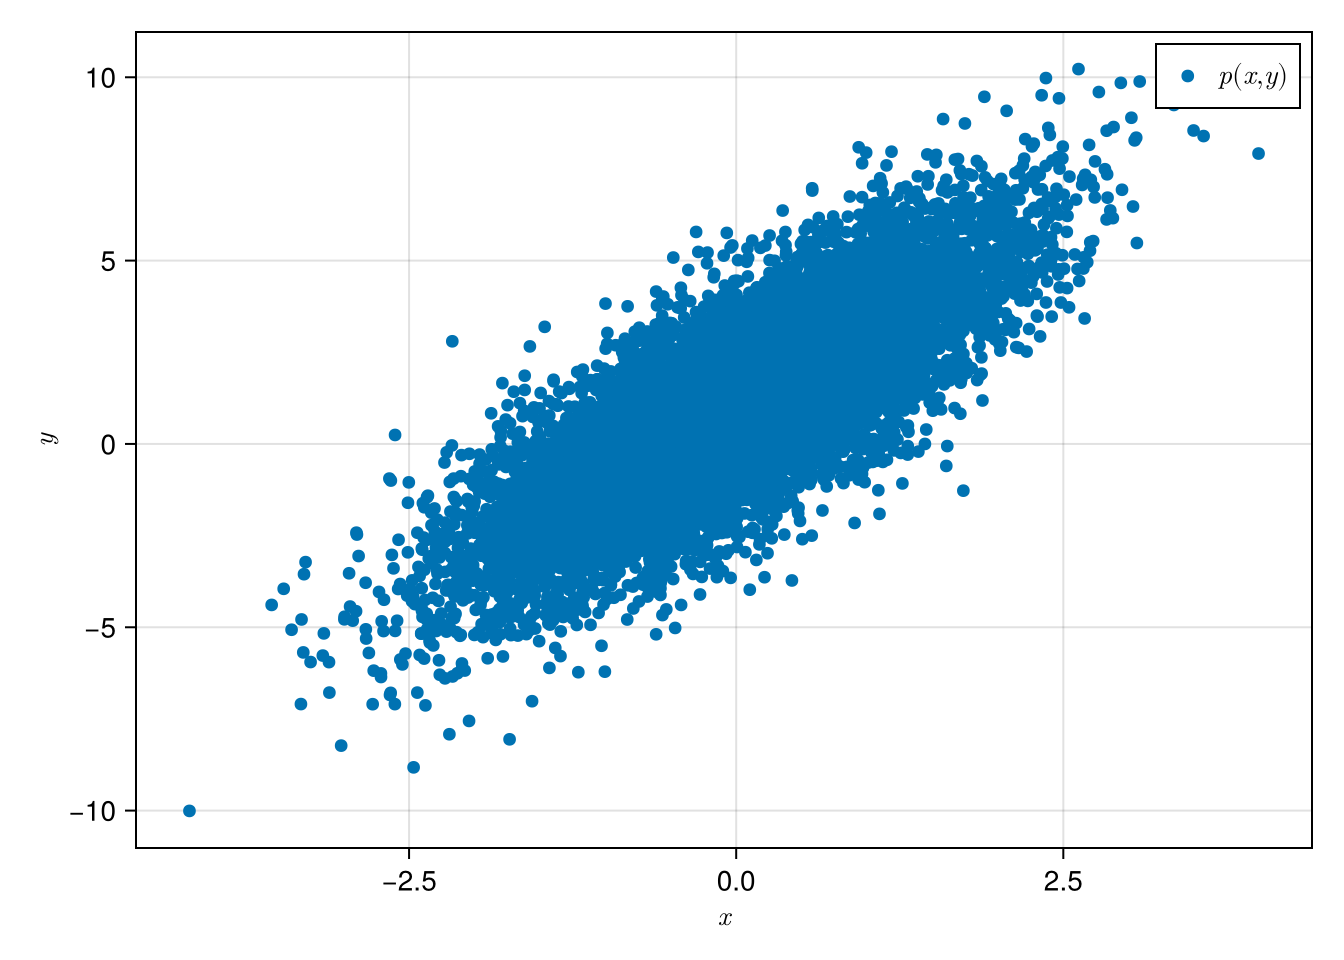

In [14]:
x = rand(Normal(0, 1), 10_000)
y = [rand(Normal(m * xᵢ + b, σ)) for xᵢ in x] ## <1>
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel=L"x",
    ylabel=L"y"
)
scatter!(ax, x, y; label=L"p(x,y)")
axislegend()
fig

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


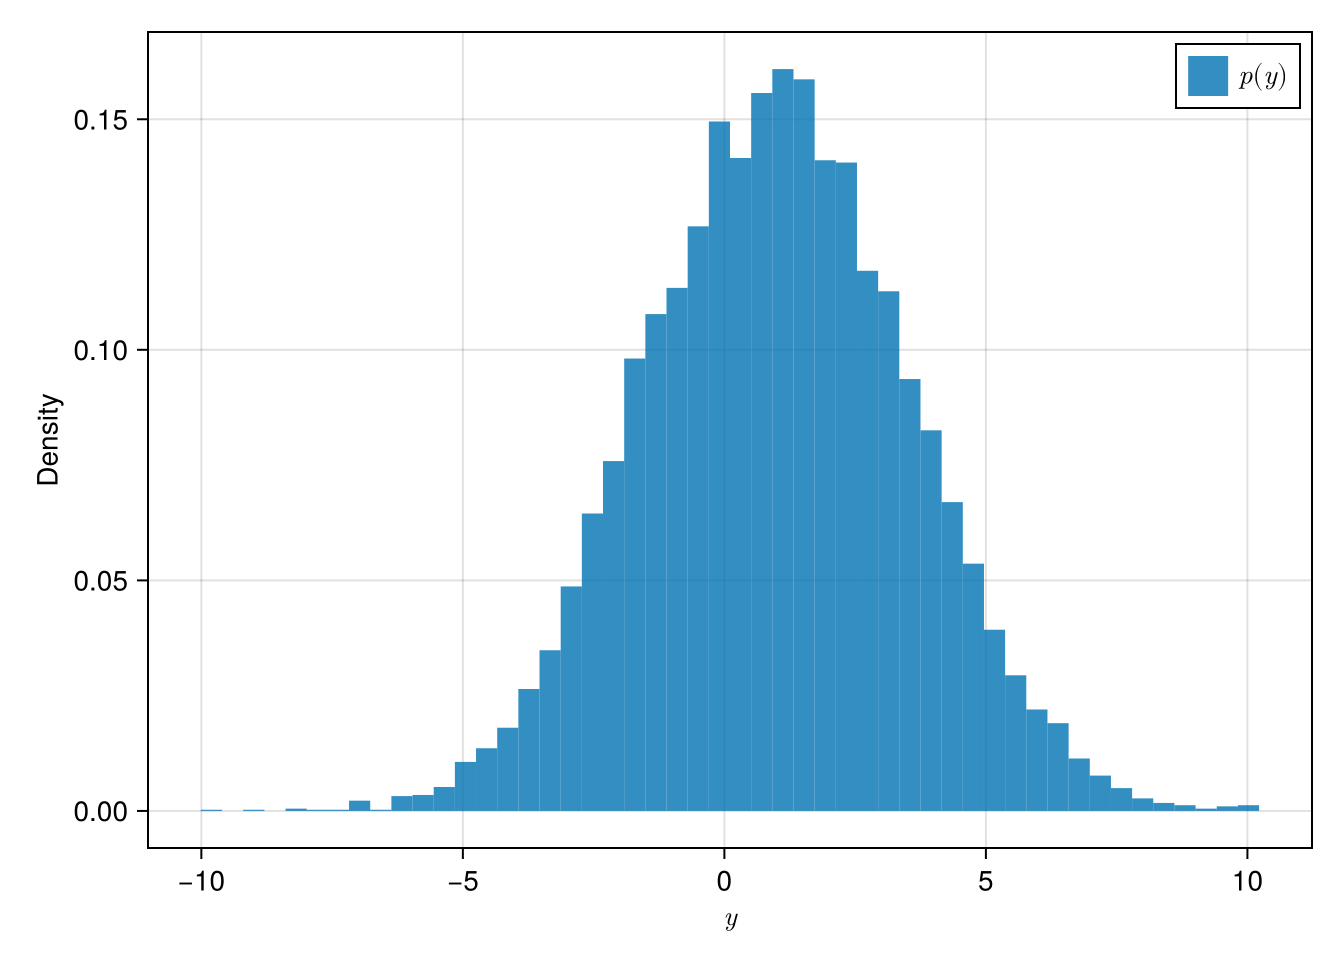

In [15]:
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel=L"y",
    ylabel="Density"
)
hist!(ax, y; bins=50, normalization=:pdf, label=L"p(y)")
axislegend()
fig

In [16]:
function gamma_poisson(r, p)
    g_dist = Gamma(r, (1 - p) / p)
    λ = rand(g_dist)
    p_dist = Poisson(λ)
    return rand(p_dist)
end

gamma_poisson (generic function with 1 method)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


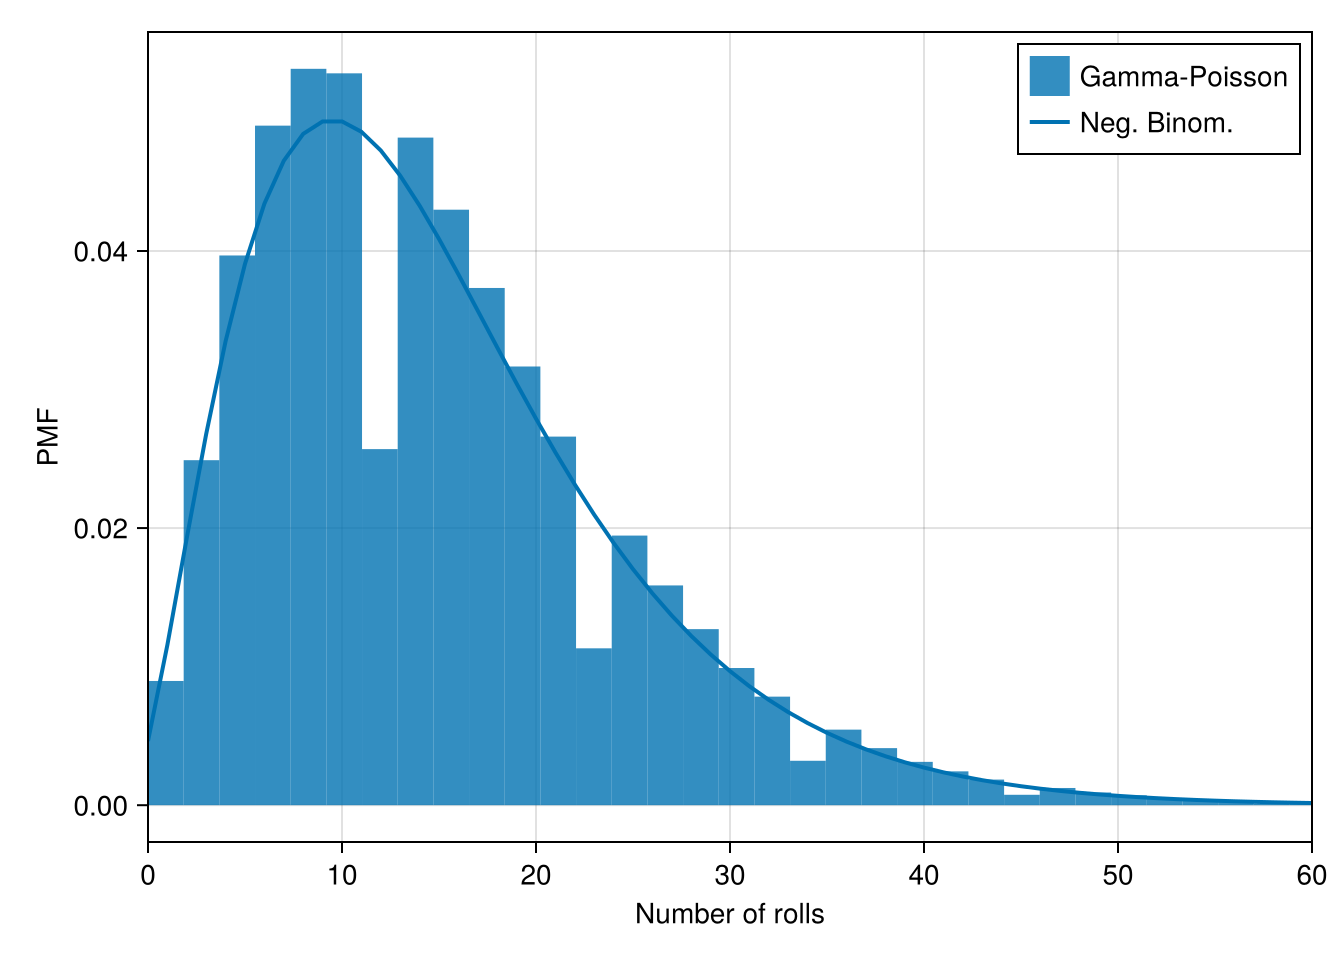

In [17]:
r = 3 # number of failures
p = 1 / 6 # probability of failure
dist = NegativeBinomial(r, p)

# simulate rolls
N = 1_000_000
rolls = [gamma_poisson(r, p) for _ in 1:N]

# plot the samples
xticks = 0:1:60 # specify the bin values
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel="Number of rolls",
    ylabel="PMF",
)

# Add histogram of simulated data
hist!(ax, rolls;
    bins=length(xticks) + 1,
    normalization=:pdf,
    label="Gamma-Poisson",
)

# Add the PDF of the negative binomial distribution
lines!(ax, xticks, pdf.(dist, xticks);
    linewidth=2,
    label="Neg. Binom."
)

xlims!(ax, 0, 60)
axislegend()
fig